# Testing DoWhy's GCM limit using confounders

The goal of this notebook is to test DoWhy's limits by forcing it to throw out an error in cases where he's unable to handle the input. Such event can happen in cases of partial identification, such as the one below.

In [18]:
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Creating the GCM

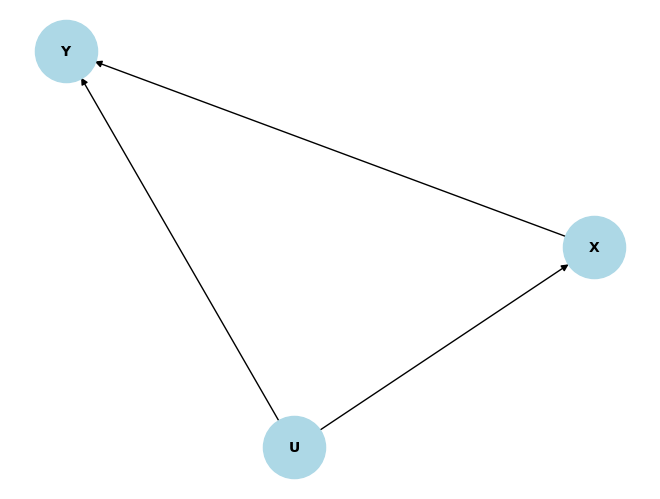

In [19]:
causal_graph = nx.DiGraph([
    ('U', 'X'),
    ('X', 'Y'),
    ('U', 'Y')
])

causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

#### Generating some data for the observed variables

In [20]:
# Number of data points to generate
num_samples = 1000

# Generate the unobserved confounder U (binary: 0 or 1)
U = np.random.binomial(1, 0.5, num_samples)  # P(U=1) = 0.5

# Generate X based on U (binary)
# P(X=1 | U=0) = 0.3, P(X=1 | U=1) = 0.7
X = np.random.binomial(1, p=0.3 + 0.4 * U, size=num_samples)

# Generate Y based on both X and U (binary)
# P(Y=1 | X=0, U=0) = 0.2, P(Y=1 | X=1, U=0) = 0.4
# P(Y=1 | X=0, U=1) = 0.6, P(Y=1 | X=1, U=1) = 0.8
Y = np.random.binomial(1, p=0.2 + 0.2 * X + 0.4 * U, size=num_samples)

# Create a DataFrame with the observed variables X and Y (U is unobserved)
data = pd.DataFrame({
    'X': X,
    'Y': Y
})

# Display the first few rows of the dataset
data.head()


,X,Y
0,1,0
1,0,0
2,0,0
3,1,0
4,1,1


#### Setting the causal mechanisms

In [21]:
#gcm.auto.assign_causal_mechanisms(causal_model, data)

causal_model.set_causal_mechanism('U', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.ClassifierFCM())
causal_model.set_causal_mechanism('Y', gcm.ClassifierFCM())

If we use the method assign_causal_mechanisms, we already obtain an error at this point and we are unable to continue.

#### Fitting the model

In [22]:
gcm.fit(causal_model, data)

Fitting causal models:   0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: Could not find data for node U in the given training data! There should be a column containing samples for node U.

## Conclusion

When using GCMs, at some point, DoWhy will stop its normal execution and give us an error whenever there are variables that are unobserved in the model